## Random Polygon Generation

`pip install cyaron` should work 

In [1]:
from cyaron import Polygon, Vector
import shapely
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

### Visualization

In [2]:
def draw_polygon(poly_point_list):
    jet = plt.cm.jet
    colors = jet(np.linspace(0, 1, len(poly_point_list)))

    # plot only polygon, no axis or frame
    fig = plt.figure(frameon=False)
    ax = plt.gca()
    ax.axis('off')
    ax.axis('equal')
    outer_vxs = poly_point_list
    wall = np.vstack((outer_vxs, outer_vxs[0]))
    wall = np.vstack((wall, np.array([np.nan, np.nan])))

    plt.plot(wall[:, 0], wall[:, 1], 'black')
    def plot_vertices(vertices):
        for index, vx in enumerate(vertices):
            plt.scatter(vx[0], vx[1], color=colors[index], s=60)

    plt.show()

## Method 1: Use the Cyaron library

Generate a random set of points. Find a random poly line connecting the points by divide and conquer. The documentation for the library is not very good and only in Chinese, but the source [here](https://github.com/luogu-dev/cyaron/blob/master/cyaron/polygon.py) is not so hard to read.

Parameters in `Vector.random`: number of points, position range for each dimension, mode (0=unique 1=repeatable 2=float).

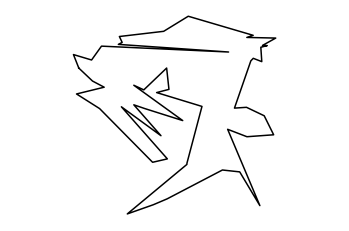

In [3]:
poly = Polygon.simple_polygon(Vector.random(50, [800, 800], 2)).points
draw_polygon(poly)

## Method 2: the Stackoverflow answer with spikyness control.

This method can only generate star shaped polygons. The code is taken from [here](https://stackoverflow.com/questions/8997099/algorithm-to-generate-random-2d-polygon).

In [4]:
import math, random

def generatePolygon( ctrX, ctrY, aveRadius, irregularity, spikeyness, numVerts ) :
    '''Start with the centre of the polygon at ctrX, ctrY, 
    then creates the polygon by sampling points on a circle around the centre. 
    Randon noise is added by varying the angular spacing between sequential points,
    and by varying the radial distance of each point from the centre.

    Params:
    ctrX, ctrY - coordinates of the "centre" of the polygon
    aveRadius - in px, the average radius of this polygon, this roughly controls how large the polygon is, really only useful for order of magnitude.
    irregularity - [0,1] indicating how much variance there is in the angular spacing of vertices. [0,1] will map to [0, 2pi/numberOfVerts]
    spikeyness - [0,1] indicating how much variance there is in each vertex from the circle of radius aveRadius. [0,1] will map to [0, aveRadius]
    numVerts - self-explanatory

    Returns a list of vertices, in CCW order.
    '''

    a = clip( irregularity, 0,1 ) * 2*math.pi / numVerts
    spikeyness = clip( spikeyness, 0,1 ) * aveRadius

    # generate n angle steps
    angleSteps = []
    lower = (2*math.pi / numVerts) - irregularity
    upper = (2*math.pi / numVerts) + irregularity
    sum = 0
    for i in range(numVerts) :
        tmp = random.uniform(lower, upper)
        angleSteps.append( tmp )
        sum = sum + tmp

    # normalize the steps so that point 0 and point n+1 are the same
    k = sum / (2*math.pi)
    for i in range(numVerts) :
        angleSteps[i] = angleSteps[i] / k

    # now generate the points
    points = []
    angle = random.uniform(0, 2*math.pi)
    for i in range(numVerts) :
        r_i = clip( random.gauss(aveRadius, spikeyness), 0, 2*aveRadius )
        x = ctrX + r_i*math.cos(angle)
        y = ctrY + r_i*math.sin(angle)
        points.append( (int(x),int(y)) )

        angle = angle + angleSteps[i]

    return points

def clip(x, min, max) :
    if( min > max ) :  return x    
    elif( x < min ) :  return min
    elif( x > max ) :  return max
    else :             return x

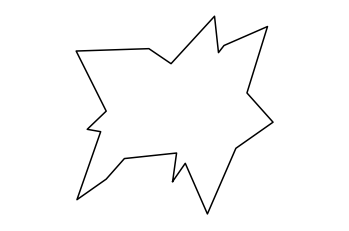

In [5]:
verts = generatePolygon( ctrX=250, ctrY=250, aveRadius=100, irregularity=0.35, spikeyness=0.3, numVerts=20 )
draw_polygon(verts)

## Method 3: RGP - Generation of Random Polygonal Objects

The paper is [here]( http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.56.5609&rep=rep1&type=pdf). For some reason the webpage for this project is not accessible anymore, so here is the Internet Wayback [link](https://web.archive.org/web/20190918003901/http://www.cosy.sbg.ac.at/~held/projects/rpg/rpg.html). I haven't read the paper yet but from the webpage their results is much more systematic than the above too. So it might worth to ask them for the code. 

## Method 4: Generate Convex Rooms Connected by Corridors

Convex polygon generation solution from [here](https://stackoverflow.com/questions/6758083/how-to-generate-a-random-convex-polygon). I modified the code so that the polygon is centered at the origin.

In [6]:
import random
from math import atan2


def to_convex_contour(vertices_count,
                      x_generator=random.random,
                      y_generator=random.random):
    """
    Port of Valtr algorithm by Sander Verdonschot.

    Reference:
        http://cglab.ca/~sander/misc/ConvexGeneration/ValtrAlgorithm.java

    >>> contour = to_convex_contour(20)
    >>> len(contour) == 20
    True
    """
    xs = [x_generator() for _ in range(vertices_count)]
    ys = [y_generator() for _ in range(vertices_count)]
    xs = sorted(xs)
    ys = sorted(ys)
    min_x, *xs, max_x = xs
    min_y, *ys, max_y = ys
    vectors_xs = _to_vectors_coordinates(xs, min_x, max_x)
    vectors_ys = _to_vectors_coordinates(ys, min_y, max_y)
    random.shuffle(vectors_ys)

    def to_vector_angle(vector):
        x, y = vector
        return atan2(y, x)

    vectors = sorted(zip(vectors_xs, vectors_ys),
                     key=to_vector_angle)
    point_x = point_y = 0
    cm_polygon_x = cm_polygon_y = 0
    points = []
    for vector_x, vector_y in vectors:
        points.append((point_x, point_y))
        point_x += vector_x
        point_y += vector_y
        cm_polygon_x += point_x
        cm_polygon_y += point_y
    cm_polygon_x /= len(points)
    cm_polygon_y /= len(points)

    return np.array([[point_x - cm_polygon_x, point_y - cm_polygon_y]
            for point_x, point_y in points])


def _to_vectors_coordinates(coordinates, min_coordinate, max_coordinate):
    last_min = last_max = min_coordinate
    result = []
    for coordinate in coordinates:
        if _to_random_boolean():
            result.append(coordinate - last_min)
            last_min = coordinate
        else:
            result.append(last_max - coordinate)
            last_max = coordinate
    result.extend((max_coordinate - last_min,
                   last_max - max_coordinate))
    return result


def _to_random_boolean():
    return random.getrandbits(1)

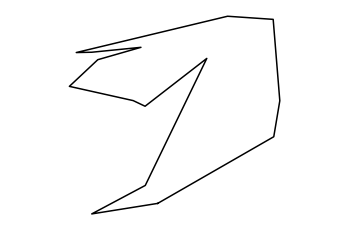

In [7]:
num_rooms = 15
corridors_map = np.array(Polygon.simple_polygon(Vector.random(num_rooms, [800, 800], 2)).points)
draw_polygon(corridors_map)

I use a randomly generated polygon as the room connection map for now. We can also triangulate the polygon to get more corridors or manually specify this. 

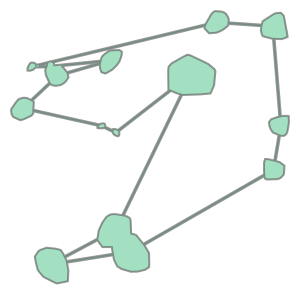

In [8]:
from shapely.ops import cascaded_union

polygon_list = []
min_room_size = 800
# Get convex rooms
for i in range(num_rooms):
    poly = to_convex_contour(20)
    room_size = 0.5 * min(la.norm(corridors_map[i] - corridors_map[(i+1)%num_rooms]), la.norm(corridors_map[i] - corridors_map[i-1]))
    poly *= room_size
    poly = np.array([point + corridors_map[i] for point in poly])
    polygon_list.append(shapely.geometry.Polygon(poly))
    min_room_size = min(min_room_size, room_size)

# Get corridors
for i in range(num_rooms):
    corridor_direction = corridors_map[i] - corridors_map[i-1]
    corridor_width_direction = np.array([corridor_direction[1], -corridor_direction[0]])
    corridor_width_direction /= la.norm(corridor_width_direction)
    corridor_width = min_room_size * 0.1
    corridor_point_list = [corridors_map[i] + corridor_width_direction * corridor_width, corridors_map[i-1] + corridor_width_direction * corridor_width, corridors_map[i-1] - corridor_width_direction * corridor_width, corridors_map[i] - corridor_width_direction * corridor_width]
    polygon_list.append(shapely.geometry.Polygon(corridor_point_list))

cascaded_union(polygon_list)